In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tiktoken
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn as nn

In [2]:
#data preparation
df = pd.read_csv('Train.csv')
full_dataset = df.rename(columns={"label": "LABEL", "text" : "DATA"})
full_dataset = full_dataset[['LABEL', 'DATA']]
full_dataset = full_dataset.to_numpy()

In [3]:
train_split = full_dataset

In [4]:
class TweetsDataset(Dataset):
    def __init__(self, full_dataset, msl):
        self.sentiment = full_dataset[:, 0]
        self.data = full_dataset[:, 1]
        self.msl = msl
        self.encoder = tiktoken.get_encoding("cl100k_base")
        
    def __len__(self):
        assert(len(self.sentiment) == len(self.data))
        return len(self.sentiment)
    
    def encode_data(self, selected_data):
        encoded_data = []
        for sd in selected_data:
            encoded_data.append(self.encoder.encode(sd))
            
        truncated_data = []
        for e in encoded_data:
            if len(e) < self.msl:
                to_add = self.msl - len(e)
                for i in range(to_add):
                    e.append(220)
                truncated_data.append(e)
            if len(e) > self.msl:
                truncated_data.append(e[:self.msl])
        return truncated_data
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        selected_data = self.data[idx]
        encoded_data = self.encode_data(selected_data)
        inputs = np.array(encoded_data).astype('float32')
        inputs = torch.tensor(inputs)
        
        targets = self.sentiment[idx]
        targets = np.array(targets).astype('int32')
        targets = torch.tensor(targets)
        targets = targets.to(torch.int64)
        one_hot = F.one_hot(targets, num_classes=2)
        
        sample = {'inputs': inputs, 'targets': one_hot}
        
        return sample

In [5]:
class MyLoader():
    def __init__(self, dataset, batch_size, generator):
        self.batch_size = batch_size
        self.dataset = dataset
        self.generator = generator
        
    def get_batch(self):
        ix = torch.randint(0, len(self.dataset), (self.batch_size,), generator = self.generator)
        return self.dataset.__getitem__(ix)

In [6]:
class Net(torch.nn.Module):
    
    def __init__(self, num_embeddings, embedding_dim, hidden_size, labels):
        super().__init__()
        
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.lstm      = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size)
        self.lin       = nn.Linear(hidden_size, labels)
     
    def forward(self, data): #torch.Size([70, 32])
        embedding_output = self.embedding(data)  
        output, (h_n, c_n) = self.lstm(embedding_output)
        h_n.squeeze_(0) #torch.Size([1, 32, 70]) -- > torch.Size([32, 70])   
        output = self.lin(h_n)
        return output

In [7]:
#CONSTS
MAX_SEQ_LEN    = 400
BATCH_SIZE     = 32
DEVICE         = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
SEED           = 25072023
NUM_EMBEDDINGS = 100264
EMBEDDING_DIM  = 1024
HIDDEN_SIZE    = 512
NUM_LAYERS     = 2        
LABELS         = 2
EPOCHS         = 1200 * 5
LR             = 0.001
BETAS          = (0.9, 0.999)
EPS            = 1e-08
WEIGHT_DECAY   = 0.01
torch.manual_seed(SEED)
g = torch.Generator(device='cpu').manual_seed(SEED)

In [8]:
training_set = TweetsDataset(train_split, MAX_SEQ_LEN)
print(len(training_set))
#validation_set = TweetsDataset(val_split, MAX_SEQ_LEN)
#print(len(validation_set))

40000


In [9]:
train_loader = MyLoader(training_set, BATCH_SIZE, generator = g)
#validation_loader = MyLoader(validation_set, BATCH_SIZE, generator = g)

In [10]:
model = Net(NUM_EMBEDDINGS, EMBEDDING_DIM, HIDDEN_SIZE, LABELS)
model.to(DEVICE)

Net(
  (embedding): Embedding(100264, 1024)
  (lstm): LSTM(1024, 512)
  (lin): Linear(in_features=512, out_features=2, bias=True)
)

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, betas=BETAS, eps=EPS, weight_decay=WEIGHT_DECAY)

In [12]:
loss_function = nn.CrossEntropyLoss()

In [13]:
lossi = []
def train(epochs, loader, net, device, optimizer, loss_function):
    net.train()
    for i in range(epochs):
        sample = loader.get_batch()
        
        if(len(sample['inputs']) == BATCH_SIZE):
            inputs, targets = sample['inputs'], sample['targets']
            inputs, targets = inputs.type(torch.int), targets.type(torch.float32)
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.T

            logits = net(inputs)
            probs = F.softmax(logits, dim=-1)
            
            loss = loss_function(probs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            lossi.append(loss.to('cpu').item())
            
            if i % 20 == 0:
                print("Epoch: {}, loss: {}".format(i, loss))
        else:
            print(i)

In [14]:
train(EPOCHS, train_loader, model, DEVICE, optimizer, loss_function)

Epoch: 0, loss: 0.6850252151489258
Epoch: 20, loss: 0.7106783390045166
Epoch: 40, loss: 0.702267050743103
Epoch: 60, loss: 0.720841646194458
66
Epoch: 80, loss: 0.6821247935295105
Epoch: 100, loss: 0.6899982690811157
106
115
Epoch: 120, loss: 0.6862781643867493
137
Epoch: 140, loss: 0.6983588933944702
145
150
154
Epoch: 160, loss: 0.7052220106124878
Epoch: 180, loss: 0.7060728073120117
Epoch: 200, loss: 0.6788838505744934
Epoch: 220, loss: 0.699862003326416
Epoch: 240, loss: 0.7313954830169678
259
Epoch: 260, loss: 0.7000592947006226
Epoch: 280, loss: 0.6752362847328186
Epoch: 300, loss: 0.6651707887649536
Epoch: 320, loss: 0.7238354086875916
Epoch: 340, loss: 0.6818631887435913
342
352
355
Epoch: 360, loss: 0.6867865324020386
Epoch: 380, loss: 0.692619264125824
388
389
390
Epoch: 400, loss: 0.6740339398384094
412
Epoch: 420, loss: 0.6824784874916077
439
Epoch: 440, loss: 0.7106152772903442
442
Epoch: 460, loss: 0.6816091537475586
Epoch: 480, loss: 0.6903717517852783
Epoch: 500, loss: 

Epoch: 4120, loss: 0.5410616993904114
Epoch: 4140, loss: 0.39121556282043457
4148
4150
4159
Epoch: 4160, loss: 0.4302107095718384
Epoch: 4180, loss: 0.4310219883918762
Epoch: 4200, loss: 0.44658809900283813
4210
Epoch: 4220, loss: 0.3759077787399292
Epoch: 4240, loss: 0.5968235731124878
Epoch: 4260, loss: 0.591062068939209
4273
Epoch: 4280, loss: 0.40946951508522034
Epoch: 4300, loss: 0.43438485264778137
4301
Epoch: 4320, loss: 0.41985243558883667
Epoch: 4340, loss: 0.4305731952190399
Epoch: 4360, loss: 0.3881600499153137
4376
Epoch: 4380, loss: 0.4659232497215271
Epoch: 4400, loss: 0.3618563711643219
Epoch: 4420, loss: 0.4361581802368164
4426
Epoch: 4440, loss: 0.3474002182483673
4450
Epoch: 4460, loss: 0.39805829524993896
4475
Epoch: 4480, loss: 0.44903990626335144
Epoch: 4500, loss: 0.42519062757492065
Epoch: 4520, loss: 0.36582618951797485
4539
Epoch: 4540, loss: 0.3774709701538086
Epoch: 4560, loss: 0.3901538550853729
Epoch: 4580, loss: 0.5034828782081604
4600
Epoch: 4620, loss: 0

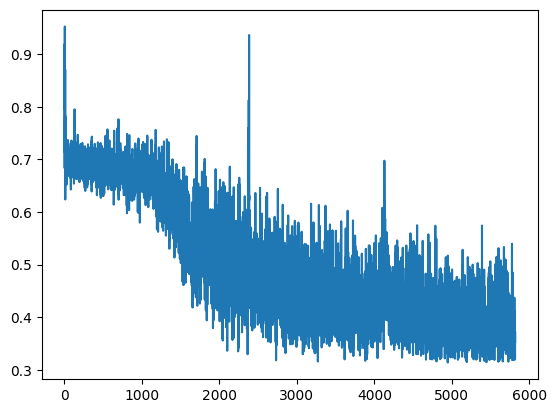

In [15]:
plt.plot(lossi)
plt.show()

In [46]:
def encode_data(selected_data):
        encoded_data = []
        encoder = tiktoken.get_encoding("cl100k_base")
        for sd in selected_data:
            encoded_data.append(encoder.encode(sd))
            
        truncated_data = []
        for e in encoded_data:
            if len(e) < 400:
                to_add = 400 - len(e)
                for i in range(to_add):
                    e.append(220)
                truncated_data.append(e)
            if len(e) > 400:
                truncated_data.append(e[:400])
        return truncated_data

In [100]:
torch.save(model.state_dict(), "sentimental_analisys.params")

In [95]:
test = '''
I was excited to watch a Christopher Nolan movie on a big screen for the first time. I'm glad, there is no IMAX near my location as it would've been a complete waste of money.

This movie is an ATOMIC mess. Story is being told in a non-linear fashion which has become the norm these days but that made it more confusing. There were no subtitles and most of the times due to changing accents and speaking very slowly it became very hard to understand what they were saying at all.

You don't feel ANYTHING about ANYONE. Women come and go like a flu. What was their purpose in the movie and Oppenheimer also had one of the most bizarre sex scene I've ever seen. Oppenheimer's wife's character is so badly written it's laughable. You don't understand anyone's intentions.

Movies dealing with science are going to be complicated that's a given fact but they made it more complicated than it needed to be.

I don't understand how are critics rating this movie so highly. This movie is not for an average audience that's what that implies.
'''

In [96]:
selected_data = [test]
encoded_data = encode_data(selected_data)
inputs = np.array(encoded_data).astype('float32')
inputs = torch.tensor(inputs)

In [97]:
inputs = inputs.type(torch.int)
inputs  = inputs.to(DEVICE)
inputs = inputs.T

In [98]:
with torch.no_grad():
    logits = model(inputs)
    probs = F.softmax(logits, dim=-1)
    idx = torch.argmax(probs)
    if(idx.item() == 0):
        print("negative")
    else:
        print("positive")

negative
